In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd 'drive/MyDrive/Data Job/Colab Notebooks/Data Science Nanodegree/Exercise Files/udacity-nanodegree-exercise/5_Experimental_Design_and_Recommendations/Lesson_5_Starbucks_Project/'

/content/drive/MyDrive/Data Job/Colab Notebooks/Data Science Nanodegree/Exercise Files/udacity-nanodegree-exercise/5_Experimental_Design_and_Recommendations/Lesson_5_Starbucks_Project


In [4]:
%ls

__pycache__/  Starbucks.ipynb  Test.csv  test_results.py  training.csv


## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

#Imports

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import scipy.stats as stats

# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [14]:
sns.set_palette('Set2')

#Functions

In [34]:
def experiment_size(p_null, p_alt, alpha = .05, beta = .20):
    """
    Compute the minimum number of samples needed to achieve a desired power
    level for a given effect size.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected
        alpha : Type-I error rate
        beta  : Type-II error rate
    
    Output value:
        n : Number of samples required for each group to obtain desired power
    """
    
    # Get necessary z-scores and standard deviations (@ 1 obs per group)
    z_null = stats.norm.ppf(1-alpha) #z 
    z_alt  = stats.norm.ppf(beta)
    sd_null = np.sqrt((1-p_null) * p_null + (1-p_null) * p_null)
    sd_alt  = np.sqrt((1-p_alt) * p_alt + (1-p_null) * p_null)
    
    # Compute and return minimum sample size
    n = pow((z_null * sd_null - z_alt * sd_alt) / (p_alt - p_null) , 2)
    return np.ceil(n)

#Import Dataset

In [6]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [6]:
# Cells for you to work and document as necessary - 
# definitely feel free to add more cells as you need

#Exploratory Data Analysis

In [7]:
train_data.shape

(84534, 10)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


This dataset does not have any missing values

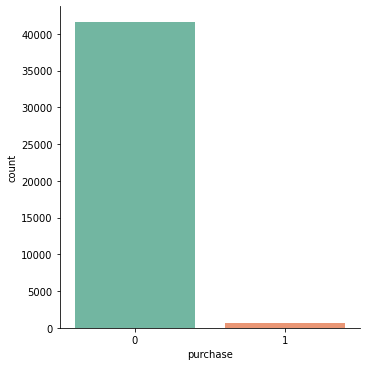

In [15]:
sns.catplot(x='purchase', kind='count', data=train_data[train_data['Promotion']=='Yes'])

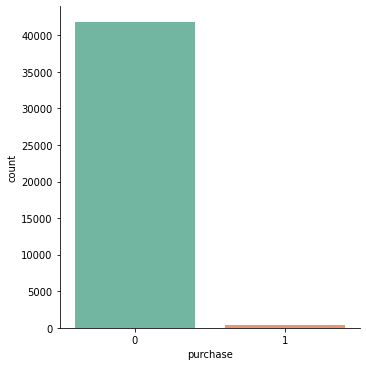

In [16]:
sns.catplot(x='purchase', kind='count', data=train_data[train_data['Promotion']=='No'])


In [24]:
print('Among {} people who did not recieve promotion, {} people made a purchase;\nAmong {} people who recieved promotion, {} people made a purchase'
      .format(train_data[train_data['Promotion']=='No'].shape[0], train_data[(train_data['Promotion']=='No') & train_data['purchase']==1].shape[0],
              train_data[train_data['Promotion']=='Yes'].shape[0], train_data[(train_data['Promotion']=='Yes') & train_data['purchase']==1].shape[0]))

Among 42170 people who did not recieve promotion, 319 people made a purchase;
Among 42364 people who recieved promotion, 721 people made a purchase


#Basic Statistical Test

Let's perform a test to figure out if the sample sizes are statistically significant

##Invariant Metric

In [29]:
# get number of trials and number of 'successes'
n_obs = train_data.shape[0]
n_control = train_data.groupby('Promotion').size()[0]

42170

Null Hypothesis: a person could just as likely to be a part of control group as to be a part of experiment group. So p (rate of success) is 0.5

In [33]:
# Compute a z-score and p-value
p = 0.5
sd = np.sqrt(p * (1-p) * n_obs)

z = ((n_control + 0.5) - p * n_obs) / sd

print('Z-score of sample', z)
print('P-value - ', 2 * stats.norm.cdf(z))

Z-score of sample -0.6638066506192843
P-value -  0.5068140685419046


P-value of the sample is 0.507 much greater than alpha level of 0.05. It means that we fail to reject the Null Hypothesis - the groups are indeed balanced, a person is just as likely to be a part of control group as in the experiment

##Experiment Size

In [39]:
#p_null
n_control = train_data[train_data['Promotion'] == 'No'].shape[0]
n_control_pur = train_data[(train_data['Promotion'] == 'No') & (train_data['purchase'] == 1)].shape[0]
p_null = n_control_pur / n_control
print('p_null - ', p_null)

p_null -  0.007564619397676073


In [40]:
#p_alt we are trying to detect
n_experiment = train_data[train_data['Promotion'] == 'Yes'].shape[0]
n_experiment_pur = train_data[(train_data['Promotion'] == 'Yes') & (train_data['purchase'] == 1)].shape[0]
p_alt = n_experiment_pur / n_experiment
print('p_alt - ', p_alt)

p_alt -  0.017019167217448776


Since we are trying to check if our sample size is enough to assert this p_alt, let's check what is the experiment size to detect this p_alt

In [44]:
print('Minimum sample size to detect {} rate increase is {}'.format(round(p_alt-p_null, 4),
                                                                    experiment_size(p_null, p_alt)))

Minimum sample size to detect 0.0095 rate increase is 1238.0


Since sample size for each group is 40 000+, we have more than enough study participants

In [10]:
def should_promote(row):
  if (row['Promotion'] == 'Yes') and (row['purchase'] == 1):
    return 1
  else:
    return 0

In [11]:
train_data['promo'] = train_data[['Promotion', 'purchase']].apply(should_promote, axis = 1)

In [12]:
train_data[train_data['purchase']==1]

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,promo
107,162,Yes,1,1,33.030562,-0.732194,2,1,1,1,1
328,503,Yes,1,3,31.760033,1.518828,2,1,2,2,1
352,534,Yes,1,2,17.512709,1.259095,2,3,4,2,1
383,580,Yes,1,1,31.043735,-1.338239,2,1,2,1,1
423,639,No,1,1,34.901993,-0.905350,2,3,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...
84300,125804,Yes,1,1,34.289793,0.047006,2,2,1,1,1
84314,125828,Yes,1,2,33.966419,1.605406,2,1,3,2,1
84388,125954,Yes,1,2,31.100225,-1.165083,2,3,2,1,1
84425,126005,Yes,1,2,32.146965,1.691984,2,3,4,2,1


In [13]:
X = train_data.drop(['Promotion', 'purchase', 'ID', 'promo'], axis = 1)
y = train_data['promo']

In [14]:
X.head()

,V1,V2,V3,V4,V5,V6,V7
0,2,30.443518,-1.165083,1,1,3,2
1,3,32.159350,-0.645617,2,3,2,2
2,2,30.431659,0.133583,1,1,4,2
3,0,26.588914,-0.212728,2,1,4,2
4,3,28.044332,-0.385883,1,1,2,2


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

#Models

In [23]:
LR_classifier = LogisticRegression(random_state = 0, solver = 'liblinear')
LR_classifier.fit(X_train, y_train)

# predictions 
y_pred = LR_classifier.predict(X_test)

#
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[27922     0]
 [  256     0]]


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     27922
           1       0.00      0.00      0.00       256

    accuracy                           0.99     28178
   macro avg       0.50      0.50      0.50     28178
weighted avg       0.98      0.99      0.99     28178



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
set(y_pred)

{0}

In [37]:
promotion = []
for prom in y_pred:
  if prom == 0:
    promotion.append('No')
  else:
    promotion.append('Yes')

promotion = np.array(promotion)

In [38]:
set(promotion)

{'No'}

In [41]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    def should_promote(row):
      if (row['Promotion'] == 'Yes') and (row['purchase'] == 1):
        return 1
      else:
        return 0
    
    train_data['promo'] = train_data[['Promotion', 'purchase']].apply(should_promote, axis = 1)
    
    X = train_data.drop(['Promotion', 'purchase', 'ID', 'promo'], axis = 1)
    y = train_data['promo']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

    LR_classifier = LogisticRegression(random_state = 0, solver = 'liblinear')
    LR_classifier.fit(X_train, y_train)

    # predictions 
    y_pred = LR_classifier.predict(X_test)

    #
    print(confusion_matrix(y_test, y_pred))
    print('\n')
    print(classification_report(y_test, y_pred))
    
    promotion = []
    for prom in y_pred:
      if prom == 0:
        promotion.append('No')
      else:
        promotion.append('Yes')

    promotion = np.array(promotion)

    return promotion

In [42]:
test_results(promotion)


TypeError: ignored

In [43]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

[[27937     0]
 [  241     0]]


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     27937
           1       0.00      0.00      0.00       241

    accuracy                           0.99     28178
   macro avg       0.50      0.50      0.50     28178
weighted avg       0.98      0.99      0.99     28178

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is nan.

Your nir with this strategy is 0.00.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/content/drive/MyDrive/Data Job/Colab Notebooks/Data Science Nanodegree/Exercise Files/udacity-nanodegree-exercise/5_Experimental_Design_and_Recommendations/Lesson_5_Starbucks_Project/test_results.py:9: RuntimeWarning: invalid value encountered in long_scalars
  irr = n_treat_purch / n_treat - n_ctrl_purch / n_control


(nan, 0.0)